## An Update

Today is Wednesday. On Monday, we figured out how to even begin accessing Gaia data and made some very preliminary plots. On Tuesday, we looked a bit more thoroughly at making RV error-based plots for the 7 million or so stars which have Gaia DR2 6D data (measured proper motions in RA and Dec, RVs, and 3D positions). One limitation of DR2 is that only a single value is reported for any source's velocity points, regardless of how many visits it had. Nevertheless, using RV errors as a proxy for binarity may hold promise.

In [14]:
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [15]:
marchettiFitsFile = 'data/GaiaDR2_vrad_vel.fits'
newFitsFile = 'data/mrawls2-result.fits.gz.fits'
with fits.open(marchettiFitsFile) as mff:
    mff_df = pd.DataFrame(np.array(mff[1].data).byteswap().newbyteorder())
with fits.open(newFitsFile) as nff:
    nff_df = pd.DataFrame(np.array(nff[1].data).byteswap().newbyteorder())
rvdf = mff_df.merge(nff_df, on='source_id')

In [16]:
bmag = rvdf['phot_bp_mean_mag']
rmag = rvdf['phot_rp_mean_mag']
gmag = rvdf['phot_g_mean_mag']
dist = rvdf['dist']

# Initial naive RV error cut
rvcut = (rvdf['radial_velocity_error'] > 5) & (rvdf['rv_nb_transits'] > 5)

# Add a column to back out the standard deviation of the epoch radial velocities
# (rather than the reported RV error, which is a 0.11 km/s constant noise floor added in quadrature
#  with the RV error on the median)
rvdf['rv_std'] = np.sqrt(rvdf['radial_velocity_error']*rvdf['radial_velocity_error'] - (0.11*0.11)) \
            / np.sqrt(np.pi/2) * np.sqrt(rvdf['rv_nb_transits'])

# Slightly improved(?) RV error cut
newrvcut = (rvdf['rv_std'] > 10) & (rvdf['rv_nb_transits'] > 5)
    
# Some useful quantities for plotting
xdat1 = bmag - rmag
ydat1 = gmag - 5*np.log10(dist) + 5
xdat2 = bmag[newrvcut] - rmag[newrvcut]
ydat2 = gmag[newrvcut] - 5*np.log10(dist[newrvcut]) + 5

## Our RV error cut samples plotted on top of the full Marchetti sample

<IPython.core.display.Javascript object>


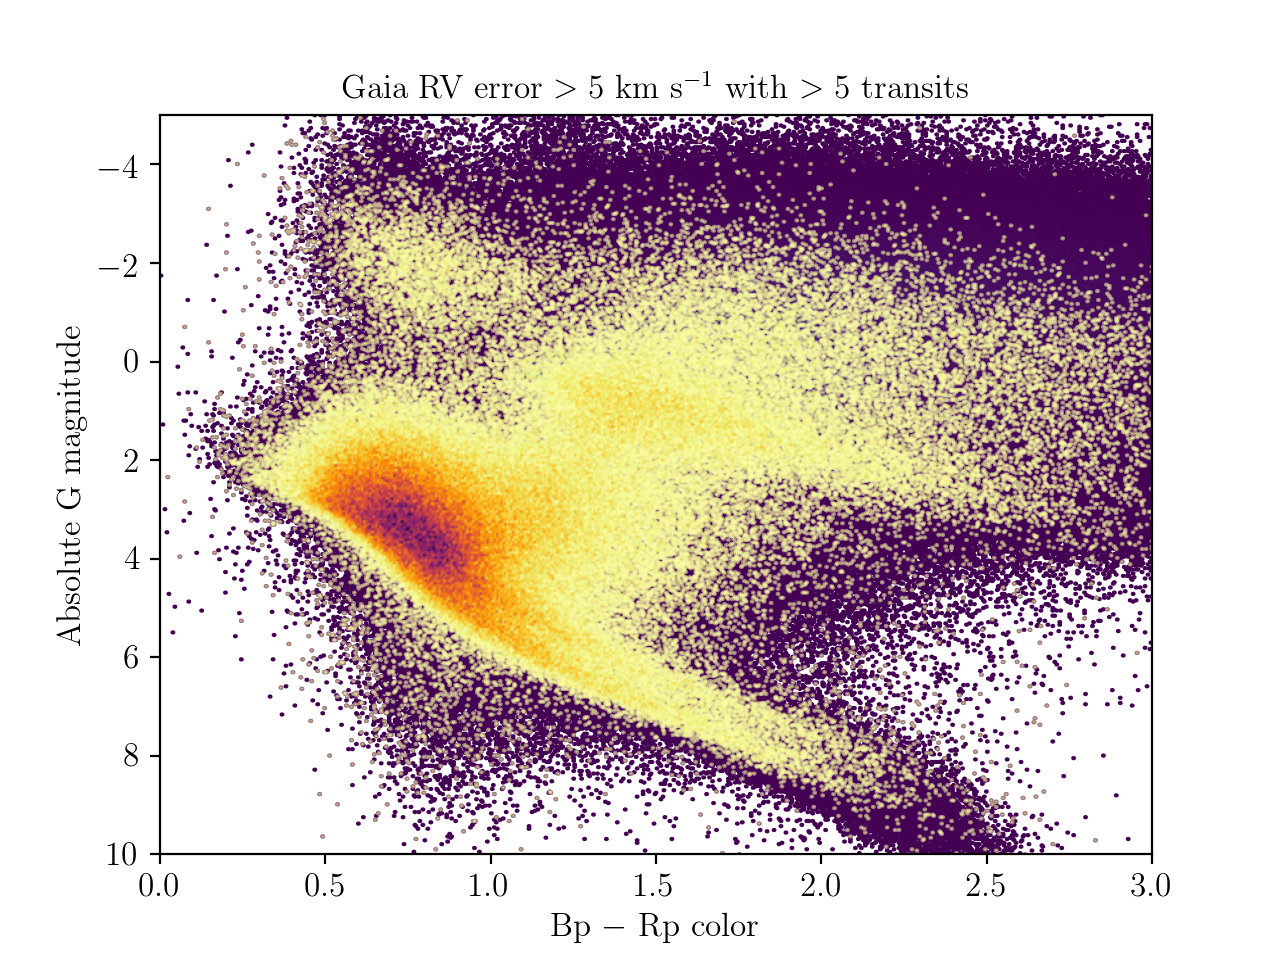

In [17]:
plt.figure()
plt.xlabel('Bp $-$ Rp color')
plt.ylabel('Absolute G magnitude')
plt.title('Gaia RV error $> 5$ km s$^{-1}$ with $> 5$ transits')
plt.gca().invert_yaxis()
plt.hexbin(bmag - rmag, gmag - 5*np.log10(dist) + 5, gridsize=500, mincnt=1, extent=(0, 3, -5, 10))
plt.hexbin(bmag[rvcut] - rmag[rvcut], gmag[rvcut] - 5*np.log10(dist[rvcut]) + 5,
           gridsize=500, mincnt=1, cmap='inferno_r', alpha=0.5, extent=(0, 3, -5, 10))

In [13]:
print(len(bmag[rvcut]), len(bmag[newrvcut]))

266184 363918


<IPython.core.display.Javascript object>


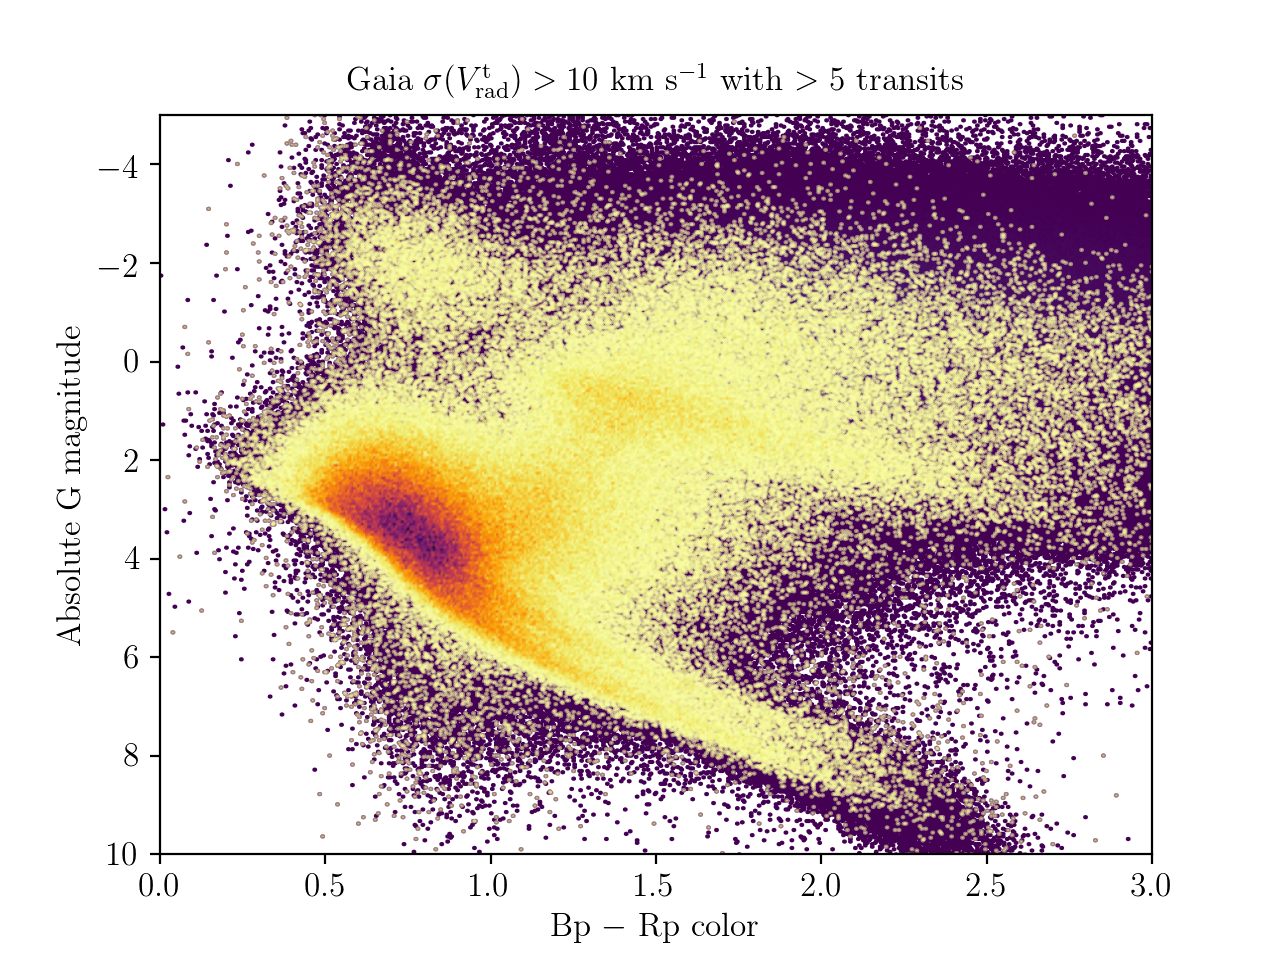

In [20]:
plt.figure()
plt.xlabel('Bp $-$ Rp color')
plt.ylabel('Absolute G magnitude')
plt.title('Gaia $\sigma (V_{\mathrm{rad}}^{\mathrm{t}}) > 10$ km s$^{-1}$ with $> 5$ transits')
plt.gca().invert_yaxis()
plt.hexbin(bmag - rmag, gmag - 5*np.log10(dist) + 5, gridsize=500, mincnt=1, extent=(0, 3, -5, 10))
plt.hexbin(bmag[newrvcut] - rmag[newrvcut], gmag[newrvcut] - 5*np.log10(dist[newrvcut]) + 5,
           gridsize=500, mincnt=1, cmap='inferno_r', alpha=0.5, extent=(0, 3, -5, 10))

## Playing around with different color maps of the second sample...

In [28]:
rvdf.columns

Index(['source_id', 'ra_x', 'dec_x', 'parallax_x', 'e_parallax', 'pmra_x',
       'e_pmra', 'pmdec_x', 'e_pmdec', 'vrad', 'e_vrad', 'GMag', 'dist',
       'el_dist', 'eu_dist', 'rGC', 'el_rGC', 'eu_rGC', 'RGC', 'el_RGC',
       'eu_RGC', 'xGC', 'el_xGC', 'eu_xGC', 'yGC', 'el_yGC', 'eu_yGC', 'zGC',
       'el_zGC', 'eu_zGC', 'U', 'el_U', 'eu_U', 'V', 'el_V', 'eu_V', 'W',
       'el_W', 'eu_W', 'UW', 'el_UW', 'eu_UW', 'vR', 'el_vR', 'eu_vR', 'vtot',
       'el_vtot', 'eu_vtot', 'P_ub', 'ra_y', 'dec_y', 'pmra_y', 'pmra_error',
       'pmdec_y', 'pmdec_error', 'rv_nb_transits', 'radial_velocity',
       'radial_velocity_error', 'phot_bp_n_obs', 'phot_rp_n_obs',
       'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
       'phot_variable_flag', 'l', 'b', 'parallax_y', 'parallax_error',
       'rv_std'],
      dtype='object')

<IPython.core.display.Javascript object>


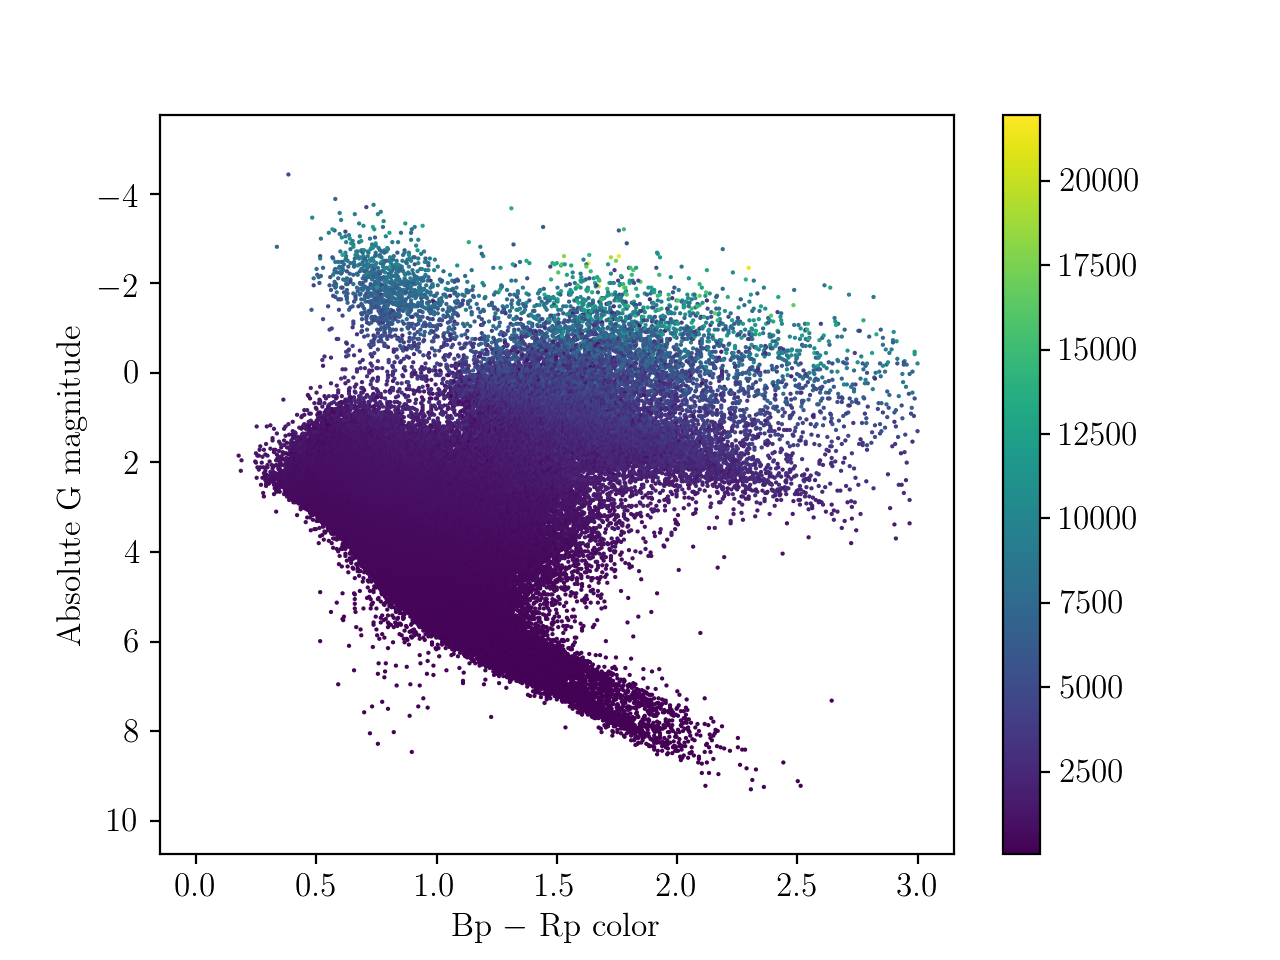

In [29]:
plt.figure()
plt.xlabel('Bp $-$ Rp color')
plt.ylabel('Absolute G magnitude')
plt.gca().invert_yaxis()
color = rvdf['dist'][newrvcut]
plt.hexbin(bmag[newrvcut] - rmag[newrvcut], gmag[newrvcut] - 5*np.log10(dist[newrvcut]) + 5,
           gridsize=500, mincnt=1, extent=(0, 3, -5, 10), C=color)
plt.colorbar()

I rediscovered the Malmquist bias! Cute.

Anyway...

There are some 3000 stars both in this `newrvcut` sample and also in APOGEE. Jen Sobeck prepared this list. It is likely so small because it's heavily main-sequence-y and APOGEE mostly targeted giants.

Meanwhile, Jim Davenport ran things from the opposite direction: given all of APOGEE (the DR14 allStar file), find Gaia sources. And do the same thing with WISE as a starting point. He shared some tables with me.

In [22]:
from astropy.table import Table
apmatch = Table.read('data/dr14_MR-rv-candidate-binary-sample.fits', format='fits')
apmatch.colnames

['APSTAR_ID',
 'TARGET_ID',
 'ASPCAP_ID',
 'FILE',
 'APOGEE_ID',
 'TELESCOPE',
 'LOCATION_ID',
 'FIELD',
 'J',
 'J_ERR',
 'H',
 'H_ERR',
 'K',
 'K_ERR',
 'RA',
 'DEC',
 'GLON',
 'GLAT',
 'APOGEE_TARGET1',
 'APOGEE_TARGET2',
 'APOGEE_TARGET3',
 'TARGFLAGS',
 'SURVEY',
 'NINST',
 'NVISITS',
 'COMBTYPE',
 'COMMISS',
 'SNR',
 'STARFLAG',
 'STARFLAGS',
 'ANDFLAG',
 'ANDFLAGS',
 'VHELIO_AVG',
 'VSCATTER',
 'VERR',
 'VERR_MED',
 'OBSVHELIO_AVG',
 'OBSVSCATTER',
 'OBSVERR',
 'OBSVERR_MED',
 'SYNTHVHELIO_AVG',
 'SYNTHVSCATTER',
 'SYNTHVERR',
 'SYNTHVERR_MED',
 'RV_TEFF',
 'RV_LOGG',
 'RV_FEH',
 'RV_ALPHA',
 'RV_CARB',
 'RV_CCFWHM',
 'RV_AUTOFWHM',
 'SYNTHSCATTER',
 'STABLERV_CHI2',
 'STABLERV_RCHI2',
 'CHI2_THRESHOLD',
 'STABLERV_CHI2_PROB',
 'APOGEE2_TARGET1',
 'APOGEE2_TARGET2',
 'APOGEE2_TARGET3',
 'MEANFIB',
 'SIGFIB',
 'SNREV',
 'APSTAR_VERSION',
 'ASPCAP_VERSION',
 'RESULTS_VERSION',
 'EXTRATARG',
 'MIN_H',
 'MAX_H',
 'MIN_JK',
 'MAX_JK',
 'PARAM',
 'FPARAM',
 'PARAM_COV',
 'FPARAM_COV',


In [24]:
'source_id' in apmatch.colnames

True

In [19]:
apmatch['APOGEE_ID'][0]

'2M00003503+6120437'

In [25]:
apmatch['source_id'][0]

565014703117182592

In [21]:
rvdf.columns

Index(['source_id', 'ra_x', 'dec_x', 'parallax_x', 'e_parallax', 'pmra_x',
       'e_pmra', 'pmdec_x', 'e_pmdec', 'vrad', 'e_vrad', 'GMag', 'dist',
       'el_dist', 'eu_dist', 'rGC', 'el_rGC', 'eu_rGC', 'RGC', 'el_RGC',
       'eu_RGC', 'xGC', 'el_xGC', 'eu_xGC', 'yGC', 'el_yGC', 'eu_yGC', 'zGC',
       'el_zGC', 'eu_zGC', 'U', 'el_U', 'eu_U', 'V', 'el_V', 'eu_V', 'W',
       'el_W', 'eu_W', 'UW', 'el_UW', 'eu_UW', 'vR', 'el_vR', 'eu_vR', 'vtot',
       'el_vtot', 'eu_vtot', 'P_ub', 'ra_y', 'dec_y', 'pmra_y', 'pmra_error',
       'pmdec_y', 'pmdec_error', 'rv_nb_transits', 'radial_velocity',
       'radial_velocity_error', 'phot_bp_n_obs', 'phot_rp_n_obs',
       'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
       'phot_variable_flag', 'l', 'b', 'parallax_y', 'parallax_error',
       'rv_std'],
      dtype='object')

In [39]:
# Only deal with the 1D columns for now
oneDcols = []
for col in apmatch.colnames:
    if len(apmatch[col].shape) == 1:
        oneDcols.append(col)

In [40]:
apmatchdf = apmatch[oneDcols].to_pandas()

In [41]:
axgdf = rvdf[newrvcut].merge(apmatchdf, on='source_id')

In [45]:
axgdf.to_csv('apogee_gaia_rvcut.csv')  # saved it!!!

In [101]:
loggOK = np.where((axgdf['LOGG'] > -9999))[0]

<IPython.core.display.Javascript object>


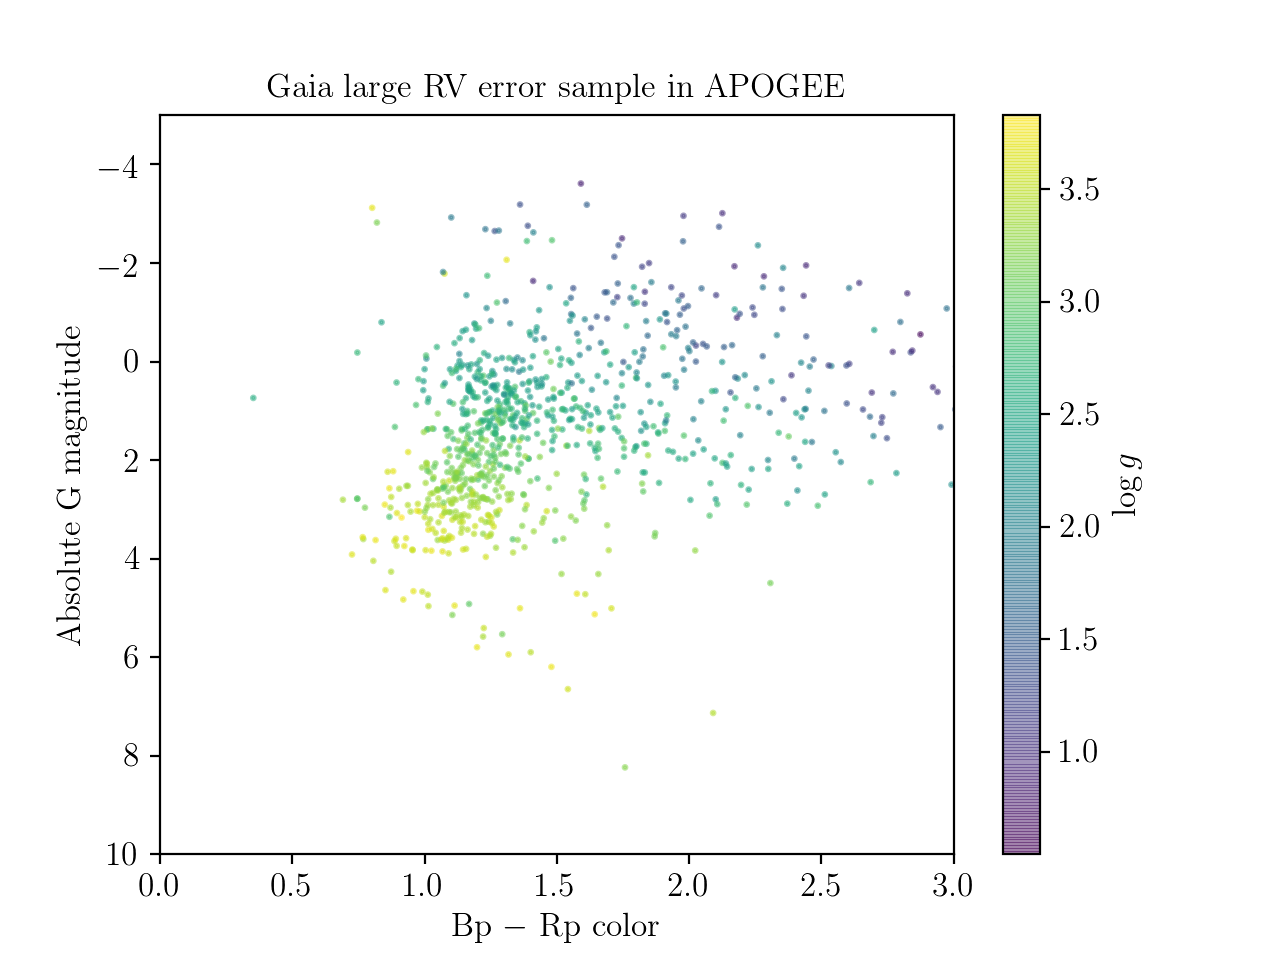

In [104]:
plt.figure()
plt.xlabel('Bp $-$ Rp color')
plt.ylabel('Absolute G magnitude')
plt.title('Gaia large RV error sample in APOGEE')
color = axgdf['LOGG'][loggOK]
plt.axis([0, 3, 10, -5])
xdata = axgdf['phot_bp_mean_mag'][loggOK] - axgdf['phot_rp_mean_mag'][loggOK]
ydata = axgdf['phot_g_mean_mag'][loggOK] - 5*np.log10(axgdf['dist'][loggOK]) + 5
plt.scatter(xdata, ydata, c=color, alpha=0.5, s=2)
plt.colorbar(label='$\log g$')

In [93]:
vsiniOK = np.where((axgdf['VSINI'] > -9999))[0]

<IPython.core.display.Javascript object>


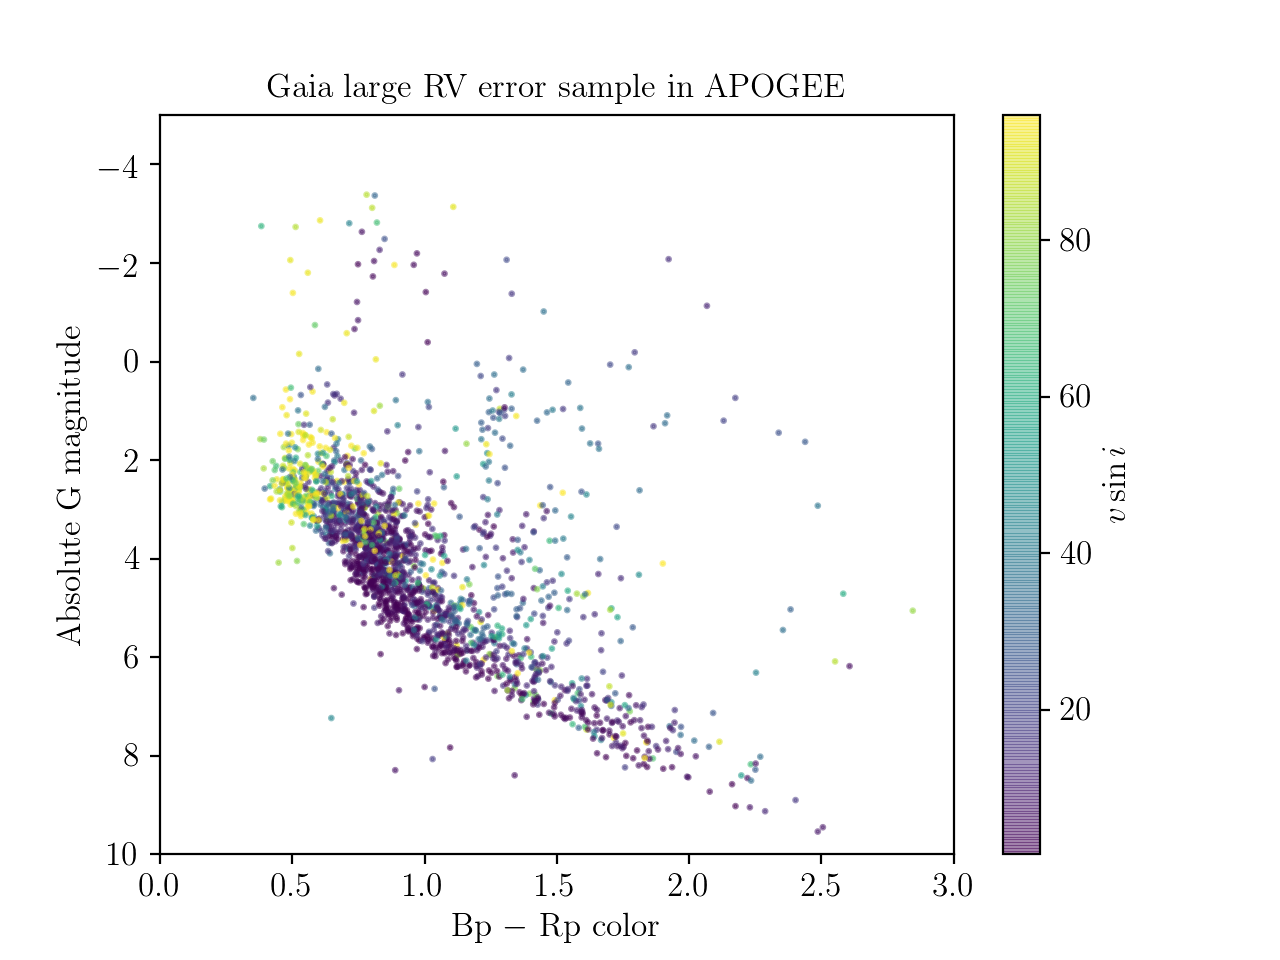

In [105]:
plt.figure()
plt.xlabel('Bp $-$ Rp color')
plt.ylabel('Absolute G magnitude')
plt.title('Gaia large RV error sample in APOGEE')
color = axgdf['VSINI'][vsiniOK]
plt.axis([0, 3, 10, -5])
xdata = axgdf['phot_bp_mean_mag'][vsiniOK] - axgdf['phot_rp_mean_mag'][vsiniOK]
ydata = axgdf['phot_g_mean_mag'][vsiniOK] - 5*np.log10(axgdf['dist'][vsiniOK]) + 5
plt.scatter(xdata, ydata, c=color, alpha=0.5, s=2)
plt.colorbar(label='$v \sin i$')

In [107]:
teffOK = np.where((axgdf['TEFF'] > -9999))[0]

<IPython.core.display.Javascript object>


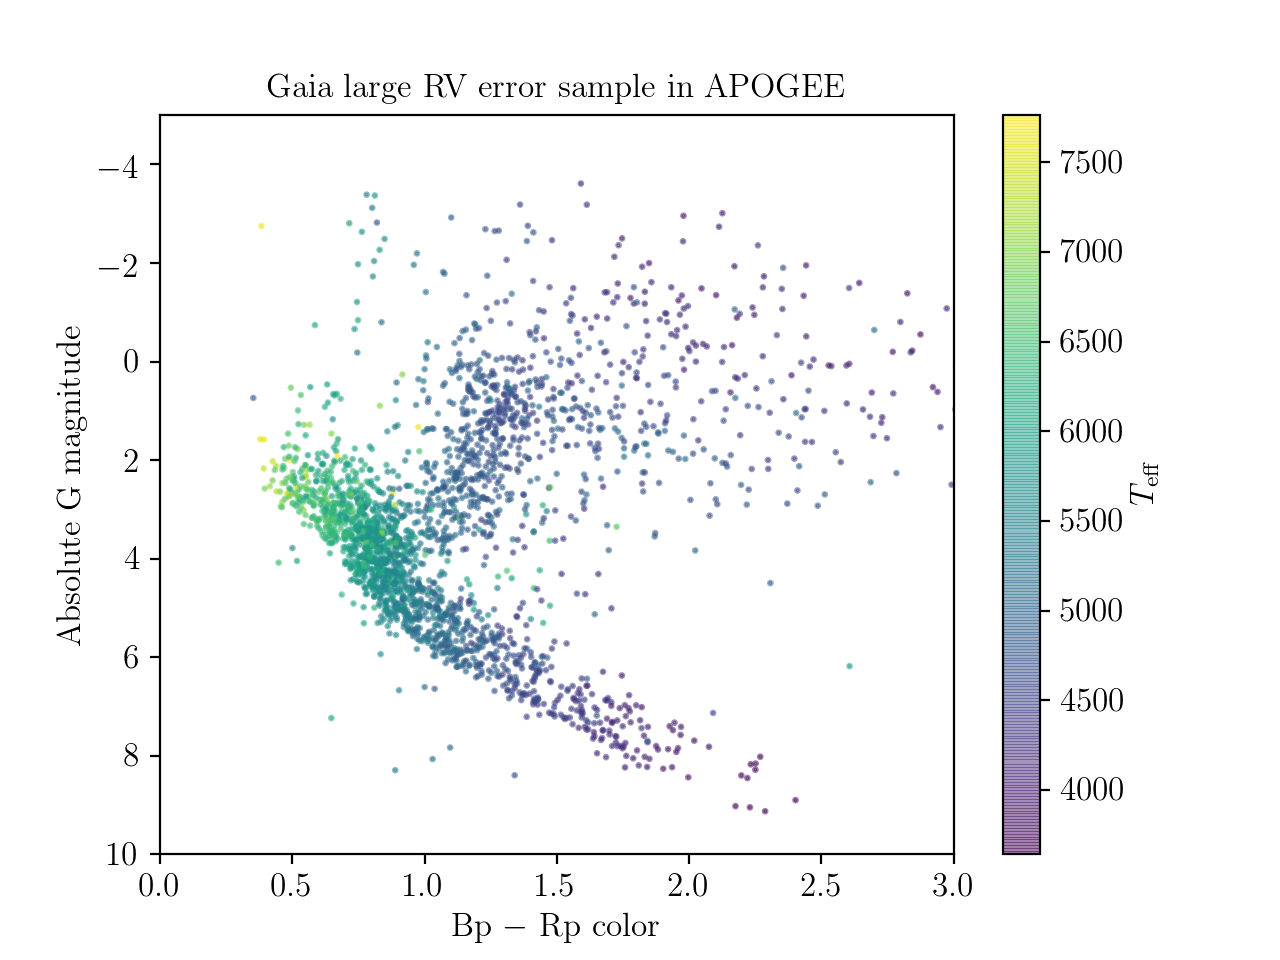

In [108]:
plt.figure()
plt.xlabel('Bp $-$ Rp color')
plt.ylabel('Absolute G magnitude')
plt.title('Gaia large RV error sample in APOGEE')
color = axgdf['TEFF'][teffOK]
plt.axis([0, 3, 10, -5])
xdata = axgdf['phot_bp_mean_mag'][teffOK] - axgdf['phot_rp_mean_mag'][teffOK]
ydata = axgdf['phot_g_mean_mag'][teffOK] - 5*np.log10(axgdf['dist'][teffOK]) + 5
plt.scatter(xdata, ydata, c=color, alpha=0.5, s=2)
plt.colorbar(label='$T_{\mathrm{eff}}$')

<IPython.core.display.Javascript object>


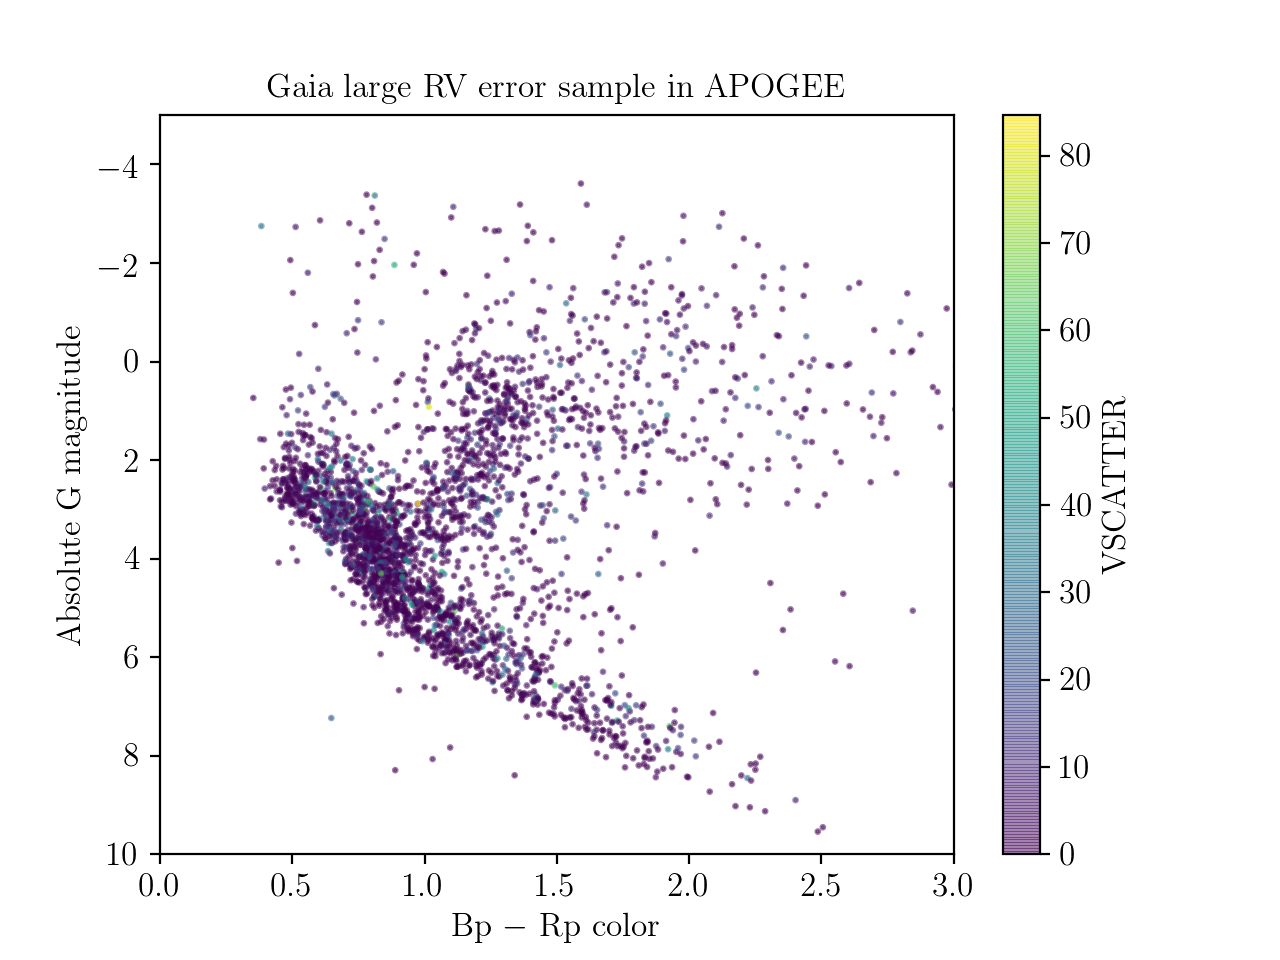

In [109]:
plt.figure()
plt.xlabel('Bp $-$ Rp color')
plt.ylabel('Absolute G magnitude')
plt.title('Gaia large RV error sample in APOGEE')
color = axgdf['VSCATTER']
plt.axis([0, 3, 10, -5])
xdata = axgdf['phot_bp_mean_mag'] - axgdf['phot_rp_mean_mag']
ydata = axgdf['phot_g_mean_mag'] - 5*np.log10(axgdf['dist']) + 5
plt.scatter(xdata, ydata, c=color, alpha=0.5, s=2)
plt.colorbar(label='VSCATTER')